In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
# import simpreglib as srl
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [46]:
df = pd.read_csv('data/cleaned_kc.csv')

In [47]:
def create_vif_dictionary(X):
    """
    Parameters
    ----------
    X: Pandas dataframe of predictive variables only.
        Should have `.columns` and `.values` attributes.
    """
    
    vif_dct = {}

    # Loop through each row and set the variable name to the VIF. 
    for i in range(len(X.columns)):
        # Calculate VIF
        vif = variance_inflation_factor(X.values, i)
        
        # Extract column name for dictionary key.
        v = X.columns[i]
        
        # Set value in dictionary.
        vif_dct[v] = vif

    return vif_dct

In [48]:
# convert age to an integer
ages = []
for age in df.age:
    age = age.split()[0]
    ages.append(float(age))
df.age = ages

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21143 entries, 0 to 21142
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21143 non-null  float64
 1   bedrooms               21143 non-null  int64  
 2   bathrooms              21143 non-null  float64
 3   sqft_living            21143 non-null  int64  
 4   sqft_lot               21143 non-null  int64  
 5   floors                 21143 non-null  float64
 6   condition              21143 non-null  int64  
 7   grade                  21143 non-null  int64  
 8   sqft_above             21143 non-null  int64  
 9   sqft_basement          21143 non-null  float64
 10  yr_built               21143 non-null  int64  
 11  sqft_living15          21143 non-null  int64  
 12  sqft_lot15             21143 non-null  int64  
 13  age                    21143 non-null  float64
 14  day_of_year            21143 non-null  int64  
 15  be

In [50]:
# because its categprical and age represents essentially the same information
df.drop('yr_built',axis=1,inplace=True)


In [51]:
y = df.price
X_labels = df.columns[1:]
X = df[X_labels]

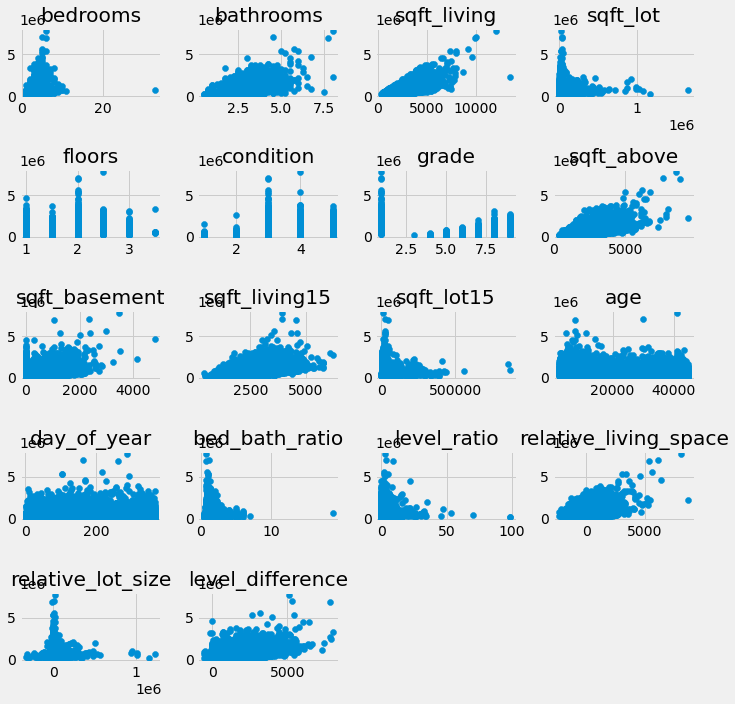

In [52]:
# visualize the relationship between the predictors and the target using scatterplots
plt.figure(figsize=(10,10))

for idx,label in enumerate(X_labels):
    ax = plt.subplot(5,4,idx+1)
    plt.scatter(X[label],y)
    plt.title(label)

plt.tight_layout()
plt.show()

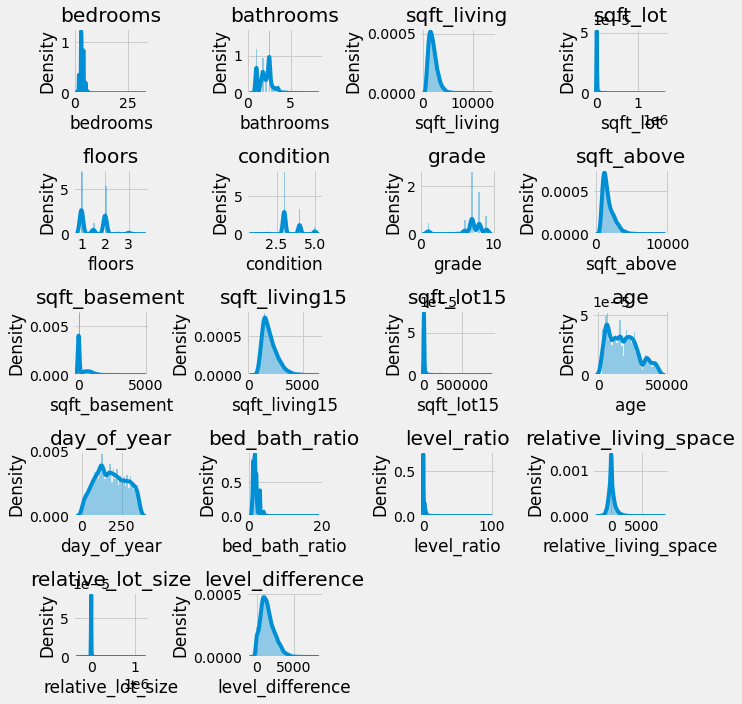

In [53]:
plt.figure(figsize=(10,10))

for idx,label in enumerate(X_labels):
    ax = plt.subplot(5,4,idx+1)
    sns.distplot(X[label],hist=True)
    plt.title(label)

plt.tight_layout()
plt.show()

In [54]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'age', 'day_of_year', 'bed_bath_ratio', 'level_ratio',
       'relative_living_space', 'relative_lot_size', 'level_difference'],
      dtype='object')

### One-hot encoding for categorical vairables

In [55]:
# one hot encode categorical variables into their own dataframes

floor_cats = X.floors.astype('category')
floor_dummies = pd.get_dummies(floor_cats,prefix='floor',drop_first=True)

cond_cats = X.condition.astype('category')
cond_dummies = pd.get_dummies(cond_cats,prefix='cond',drop_first=True)

grade_cats = X.grade.astype('category')
grade_dummies = pd.get_dummies(grade_cats,prefix='grade',drop_first=True)

bed_cats = X.bedrooms.astype('category')
bed_dummies = pd.get_dummies(grade_cats,prefix='beds',drop_first=True)

bath_cats = X.bedrooms.astype('category')
bath_dummies = pd.get_dummies(grade_cats,prefix='beds',drop_first=True)


In [56]:
model_data = pd.concat([X,floor_dummies,cond_dummies,grade_dummies,bed_dummies,bath_dummies],axis=1)
#dropping columns that have been one hot encoded, duplicitous data
model_data.drop(['bedrooms','bathrooms','floors','condition','grade'],axis=1,inplace=True) 

In [57]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2211.
Date:                Sat, 12 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:46:00   Log-Likelihood:            -2.9143e+05
No. Observations:               21143   AIC:                         5.829e+05
Df Residuals:                   21128   BIC:                         5.830e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -4.45e+05   2.01e+04    -22.097      0.000   -4.84e+05   -4.06e+05
bedrooms              -1.128e+05   3960.724    -28.481      0.000   -1.21e+05   -1.05e+05
bathrooms              1.641e+05   6848.417     23.956      0.000    1.51e+05    1.77e+05
sqft_living             137.7892      1.644     83.822      0.000     134.567     141.011
sqft_lot                 -0.2369      0.027     -8.792      0.000      -0.290      -0.184
floors                 6.667e+04   4153.866     16.049      0.000    5.85e+04    7.48e+04
condition              2.678e+04   2711.422      9.877      0.000    2.15e+04    3.21e+04
grade                 -2.184e+04    928.207    -23.534      0.000   -2.37e+04      -2e+04
sqft_above               65.8029      0.944     69.683      0.000      63.952      67.654
sqft_basement            71.9863      1.374     52.395      0.000      69.293      74.679
sqft_living15           118.1640      2.039     57.966      0.000     114.168     122.160
sqft_lot15               -0.4449      0.046     -9.590      0.000      -0.536      -0.354
age                       8.3239      0.201     41.441      0.000       7.930       8.718
day_of_year             -86.1136     17.035     -5.055      0.000    -119.503     -52.724
bed_bath_ratio         1.069e+05   6227.591     17.171      0.000    9.47e+04    1.19e+05
level_ratio            7365.3134    661.111     11.141      0.000    6069.486    8661.141
relative_living_space    19.6251      2.065      9.502      0.000      15.577      23.673
relative_lot_size         0.2080      0.044      4.700      0.000       0.121       0.295
level_difference         -6.1834      1.690     -3.659      0.000      -9.496      -2.871
==============================================================================
Omnibus:                    14259.260   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           622235.792
Skew:                           2.690   Prob(JB):                         0.00
Kurtosis:                      29.026   Cond. No.                     2.74e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.29e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [58]:
const = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'age', 'day_of_year', 'bed_bath_ratio', 'level_ratio',
       'relative_living_space', 'relative_lot_size', 'level_difference']

In [59]:
create_vif_dictionary(X)

{'bedrooms': 58.32118384194414,
 'bathrooms': 57.84054290751994,
 'sqft_living': inf,
 'sqft_lot': inf,
 'floors': 15.926052423084142,
 'condition': 27.9388737465139,
 'grade': 13.70204366610633,
 'sqft_above': inf,
 'sqft_basement': inf,
 'sqft_living15': inf,
 'sqft_lot15': inf,
 'age': 6.881296527889314,
 'day_of_year': 4.6860289878245736,
 'bed_bath_ratio': 30.0137067238,
 'level_ratio': 1.3218881314724718,
 'relative_living_space': inf,
 'relative_lot_size': inf,
 'level_difference': inf}

In [60]:
MAE = mean_absolute_error(y,model.predict())
MSE = mean_squared_error(y,model.predict())
rSE = np.sqrt(MSE)

print("Mean Absolute Error: ", MAE)
print("Mean Squared Error: ", MSE)
print("Root Mean Squared Error: ", rSE)

Mean Absolute Error:  154478.3567393836
Mean Squared Error:  54951539509.7118
Root Mean Squared Error:  234417.4471103032


In [61]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 622235.7921788504),
 ('Prob', 0.0),
 ('Skew', 2.6899578038143273),
 ('Kurtosis', 29.026399014921562)]

### Observations

Items in pushin_p list show acceptable Pvalues, while items in maybe_p show unaccaptable Pvalues (P > 0.05) they visually appear to show a linear relationship on the scatter plot so they should be further investigated and perhaps transformed for a better fit into the OLS model. While items in pushin_vif are the only items that show acceptable variance inflation factors (VIF). 'day_of_year' and 'level_ratio' show acceptable VIF as well as acceptable Pvalues, indicating good confidence in these data features. 

The Durbin-Watson score is nearly perfect, which I find suspicious to say the least considering the obnoxious lack of normality amongst all the features. 

The root mean squared error is ASTRONOMICAL which means it is probably worth looking into standardizing the units accross feature. My intuition is that this is at least impart due to there being so man different units of measurement used among the continuous variables in the dataset. 

The Jarque-Bera score is through the roof, with a Pvalue of 0.0 indicating the null hypothesis that the data is normal should definitely be rejected; the skew and kurtosis is consistent with the model however. 

The model as a whole presents an extreme skewness as well as kurtosis, these statitics should reduce as the model improves; skewness and kurtosis should both move toward 1, skewness should go at least below zero and kurtosis should get as close to 3 as possible. This would indicate the data distribution finding a more "normal" shape. 

In [ ]:
# from pathlib import Path  
# # model_data['price'] = y
# filepath = Path('data/one_hot_one.csv')  
# filepath.parent.mkdir(parents=True, exist_ok=True)  
# model_data.to_csv(filepath,index=False)

In [94]:
cont_log = pd.DataFrame([])

cont_log['sqft_living'] = np.log(X['sqft_living'])
cont_log['sqft_lot'] = np.log(X['sqft_lot'])
cont_log['sqft_above'] = np.log(X['sqft_above'])
cont_log['sqft_basement'] = np.log(X['sqft_basement']) # too many -inf
cont_log['sqft_living15'] = np.log(X['sqft_living15']) 
cont_log['sqft_lot15'] = np.log(X['sqft_lot15'])
cont_log['age'] = np.log(X['age'])
cont_log['day_of_year'] = np.log(X['day_of_year'])
cont_log['bed_bath_ratio'] = np.log(X['bed_bath_ratio'])
cont_log['level_ratio'] = np.log(X['level_ratio']) # too many -inf
cont_log['relative_living_space'] = np.log(X['relative_living_space']) # NaN should be 0
cont_log['relative_lot_size'] = np.log(X['relative_lot_size']) # more -inf, NaN should be 0 
cont_log['level_difference'] = np.log(X['level_difference']) 

cont_log.replace(np.NaN, 0,inplace=True)
cont_log['sqft_basement'].replace(np.NINF,-8.480529,inplace=True)
cont_log['level_ratio'].replace(np.NINF,-4.595120,inplace=True)
cont_log['relative_living_space'].replace(np.NINF,-9.069928,inplace=True)
cont_log['relative_lot_size'].replace(np.NINF,-14.019086,inplace=True)
cont_log['level_difference'].replace(np.NINF,-8.989694,inplace=True)


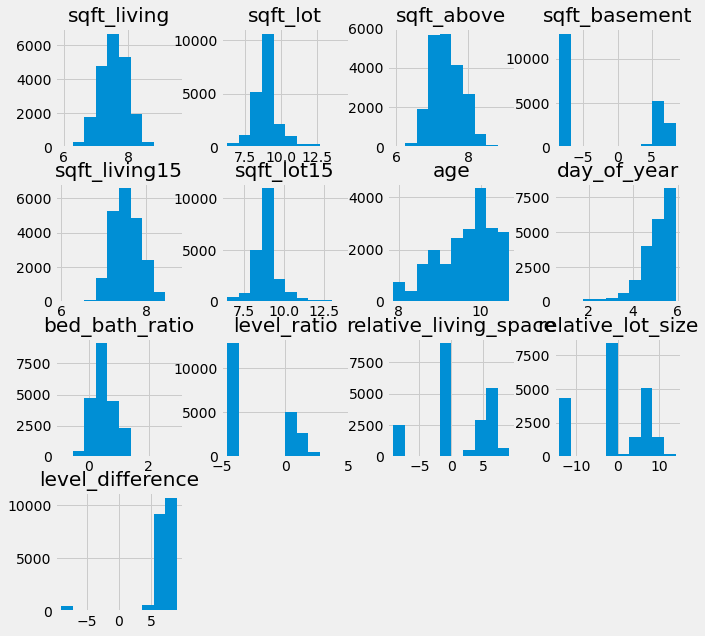

In [95]:
cont_log.hist(figsize=(10,10))
plt.show()

In [100]:
cont_log.level_ratio.value_counts()

-4.595120    12826
 0.000000      538
 0.693147      120
 1.098612       33
 0.405465       30
             ...  
 0.025752        1
 0.073122        1
 2.125251        1
 1.479626        1
 1.324222        1
Name: level_ratio, Length: 4812, dtype: int64

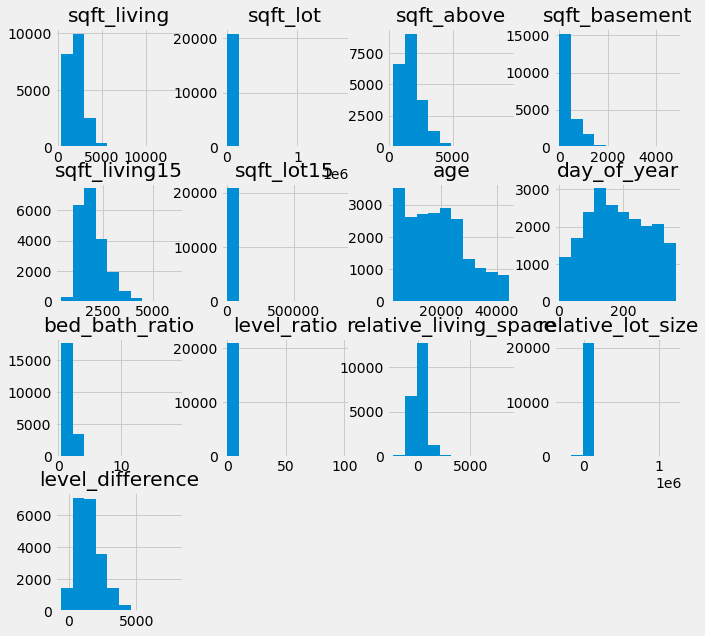

In [99]:
X[const].hist(figsize=(10,10))

plt.show()